# Scent Detection Model for TeleScent

This notebook trains a machine learning model to detect **12 different scents** from Arduino sensor readings using the **master dataset** with 9,070 real samples.

## Dataset Overview

- **Total Samples**: 9,070 sensor readings
- **Scents**: 12 (apple, banana, coconut, coffee, grape, icecream, lavender, lemon, mango, melon, orange, pineapple)
- **Sensor Features**: 10 sensors (temperature, humidity, pressure, gas, VOC, NOx, NO2, ethanol, etc.)

### Detection Phases

Your dataset captures 4 phases of scent detection:

| Phase | Description | Samples | Purpose |
|-------|-------------|---------|---------|
| **Baseline** | Before scent exposure | 1,500 | Reference values |
| **Exposure** | Scent getting stronger | 4,440 | Primary detection |
| **Recovery** | Scent dissipating | 2,997 | Return to baseline |
| **Outside Protocol** | Additional measurements | 132 | Validation |

### Workflow
```
Arduino Sensors → Backend API → ML Model → Scent Prediction
   (10 sensors)      (JSON)      (Random Forest)   (12 scents)
```

## 1. Import Required Libraries

In [25]:
import os
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Define Features and Configuration

In [26]:
# Define sensor features (matching your master dataset column names)
# IMPORTANT: Focus ONLY on chemical sensors that respond to scent molecules
# REMOVED: temp_C, humidity_pct, pressure_kPa (environmental, not scent-specific)

COLUMN_MAPPING = {
    # 'temp_C': 'temperature',           # REMOVED - environmental
    # 'humidity_pct': 'humidity',        # REMOVED - environmental
    # 'pressure_kPa': 'pressure',        # REMOVED - not scent-dependent
    'gas_bme': 'gas',                    # Gas resistance - IMPORTANT
    'srawVoc': 'voc_raw',                # Raw VOC - VERY IMPORTANT
    'srawNox': 'nox_raw',                # Raw NOx signal
    'NO2': 'no2',                        # Nitrogen dioxide
    'ethanol': 'ethanol',                # Ethanol compounds - IMPORTANT
    'VOC_multichannel': 'voc',           # VOC index - MOST IMPORTANT
    'COandH2': 'co_h2'                   # CO and H2 gases - IMPORTANT
}

FEATURES = list(COLUMN_MAPPING.keys())

# Configuration
DATA_PATH = 'master_dataset1.csv'  # Your master dataset
MODEL_DIR = 'model'  # Output directory for trained model
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Phases in your dataset
PHASES = ['baseline', 'exposure', 'recovery', 'outside_protocol']

print(f"🔬 Chemical Sensors Only: {FEATURES}")
print(f"Number of features: {len(FEATURES)}")
print(f"\n⚠️  EXCLUDED: temp_C, humidity_pct, pressure_kPa (environmental variables)")
print(f"✅ FOCUS: Gas and VOC sensors that directly detect scent molecules")
print(f"\n🎯 Most Important for Scents:")
print(f"   1. VOC_multichannel - Volatile organic compounds")
print(f"   2. gas_bme - Gas sensor resistance") 
print(f"   3. srawVoc - Raw VOC signal")
print(f"   4. ethanol - Alcohol compounds")
print(f"\nPhases in dataset:")
print(f"  - baseline: Initial state before scent exposure")
print(f"  - exposure: Scent is getting stronger")
print(f"  - recovery: Scent is getting weaker")
print(f"  - outside_protocol: New units being measured")

🔬 Chemical Sensors Only: ['gas_bme', 'srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2']
Number of features: 7

⚠️  EXCLUDED: temp_C, humidity_pct, pressure_kPa (environmental variables)
✅ FOCUS: Gas and VOC sensors that directly detect scent molecules

🎯 Most Important for Scents:
   1. VOC_multichannel - Volatile organic compounds
   2. gas_bme - Gas sensor resistance
   3. srawVoc - Raw VOC signal
   4. ethanol - Alcohol compounds

Phases in dataset:
  - baseline: Initial state before scent exposure
  - exposure: Scent is getting stronger
  - recovery: Scent is getting weaker
  - outside_protocol: New units being measured


### 🔬 Feature Selection Strategy

**Chemical Sensors Only (6 features)**

We use ONLY sensors that directly respond to scent chemistry:

| Sensor | Why Important | What It Detects |
|--------|---------------|-----------------|
| **VOC_multichannel** 🌟 | PRIMARY | Volatile organic compounds - the molecules that make scents |
| **gas_bme** 🌟 | PRIMARY | Gas resistance changes with scent molecules |
| **srawVoc** 🌟 | PRIMARY | Raw VOC signal - unprocessed scent detection |
| **ethanol** ⭐ | SECONDARY | Alcohol-based scent compounds |
| **NO2** ⭐ | SECONDARY | Nitrogen compounds in scents |
| **COandH2** ⭐ | SECONDARY | Reducing gases from scent chemistry |
| **srawNox** | TERTIARY | NOx variations |

**Excluded (Environmental Variables):**
- ❌ `temp_C` - Room temperature (not scent-specific)
- ❌ `humidity_pct` - Air humidity (not scent-specific)
- ❌ `pressure_kPa` - Atmospheric pressure (not scent-related)

**Why exclude environmental sensors?**
- They measure room conditions, not scent properties
- They can vary between trials and introduce noise
- They shouldn't be predictive of scent type
- If they appear important, it means they're capturing experimental artifacts, not scent chemistry

## 3. Load Training Data

**Note:** Your training CSV should have:
- Columns for all sensor features listed above
- A `label` or `scent` column with the scent name (e.g., "coffee", "vanilla", "lemon", etc.)

In [27]:
# Load master dataset
try:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Master dataset loaded successfully!")
    print(f"   Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
    
    print(f"Columns in dataset:\n{list(df.columns)}\n")
    
    # Show first few rows
    print("First few rows:")
    display(df.head(10))
    
    # Dataset info
    print(f"\n📊 Dataset Statistics:")
    print(f"   Unique scents: {df['scent_name'].nunique()}")
    print(f"   Scent names: {sorted(df['scent_name'].unique())}")
    print(f"\n   Unique phases: {df['phase'].nunique()}")
    print(f"   Phase names: {sorted(df['phase'].unique())}")
    print(f"\n   Trials: {df['trial_number'].nunique()}")
    print(f"   Samples: {df['sample_id'].nunique()}")
    
    # Class distribution
    print(f"\n🎯 Scent distribution:")
    print(df['scent_name'].value_counts().sort_index())
    
    print(f"\n📈 Phase distribution:")
    print(df['phase'].value_counts())
    
    label_col = 'scent_name'
    
except FileNotFoundError:
    print(f"❌ Master dataset not found at {DATA_PATH}")
    print(f"   Please ensure master_dataset1.csv is in the ml/ folder")
    df = None

✅ Master dataset loaded successfully!
   Shape: 9069 rows, 16 columns

Columns in dataset:
['sample_id', 'trial_number', 'scent_id', 'scent_name', 'phase', 'time_s', 'temp_C', 'humidity_pct', 'pressure_kPa', 'gas_bme', 'srawVoc', 'srawNox', 'NO2', 'ethanol', 'VOC_multichannel', 'COandH2']

First few rows:


,sample_id,trial_number,scent_id,scent_name,phase,time_s,temp_C,humidity_pct,pressure_kPa,gas_bme,srawVoc,srawNox,NO2,ethanol,VOC_multichannel,COandH2
0,1,1,7,apple,baseline,0.000,23.48,32.58,100.94,113.87,30646,14583,223,371,394,855
1,1,1,7,apple,baseline,1.215,23.48,32.59,100.94,112.87,30656,14576,224,371,394,856
2,1,1,7,apple,baseline,2.430,23.48,32.58,100.94,113.25,30624,14576,224,371,394,857
3,1,1,7,apple,baseline,3.645,23.47,32.58,100.94,114.18,30605,14580,223,370,394,857
4,1,1,7,apple,baseline,4.860,23.47,32.58,100.94,113.95,30614,14576,223,370,393,858
5,1,1,7,apple,baseline,6.075,23.47,32.57,100.94,114.33,30659,14583,223,370,393,856
6,1,1,7,apple,baseline,7.290,23.47,32.59,100.94,113.79,30666,14584,222,370,392,855
7,1,1,7,apple,baseline,8.505,23.47,32.57,100.94,114.65,30657,14575,222,370,392,855
8,1,1,7,apple,baseline,9.720,23.47,32.57,100.94,114.26,30706,14584,220,369,391,854
9,1,1,7,apple,baseline,10.935,23.47,32.60,100.94,113.64,30657,14578,221,369,392,853



📊 Dataset Statistics:
   Unique scents: 12
   Scent names: ['apple', 'banana', 'coconut', 'coffee', 'grape', 'icecream', 'lavender', 'lemon', 'mango', 'melon', 'orange', 'pineapple']

   Unique phases: 4
   Phase names: ['baseline', 'exposure', 'outside_protocol', 'recovery']

   Trials: 5
   Samples: 60

🎯 Scent distribution:
scent_name
apple        746
banana       767
coconut      753
coffee       784
grape        750
icecream     755
lavender     747
lemon        747
mango        757
melon        752
orange       749
pineapple    762
Name: count, dtype: int64

📈 Phase distribution:
phase
exposure            4440
recovery            2997
baseline            1500
outside_protocol     132
Name: count, dtype: int64


### 3.1 Analyze Phases (Optional)

Understanding how sensor readings change across different phases of scent detection.

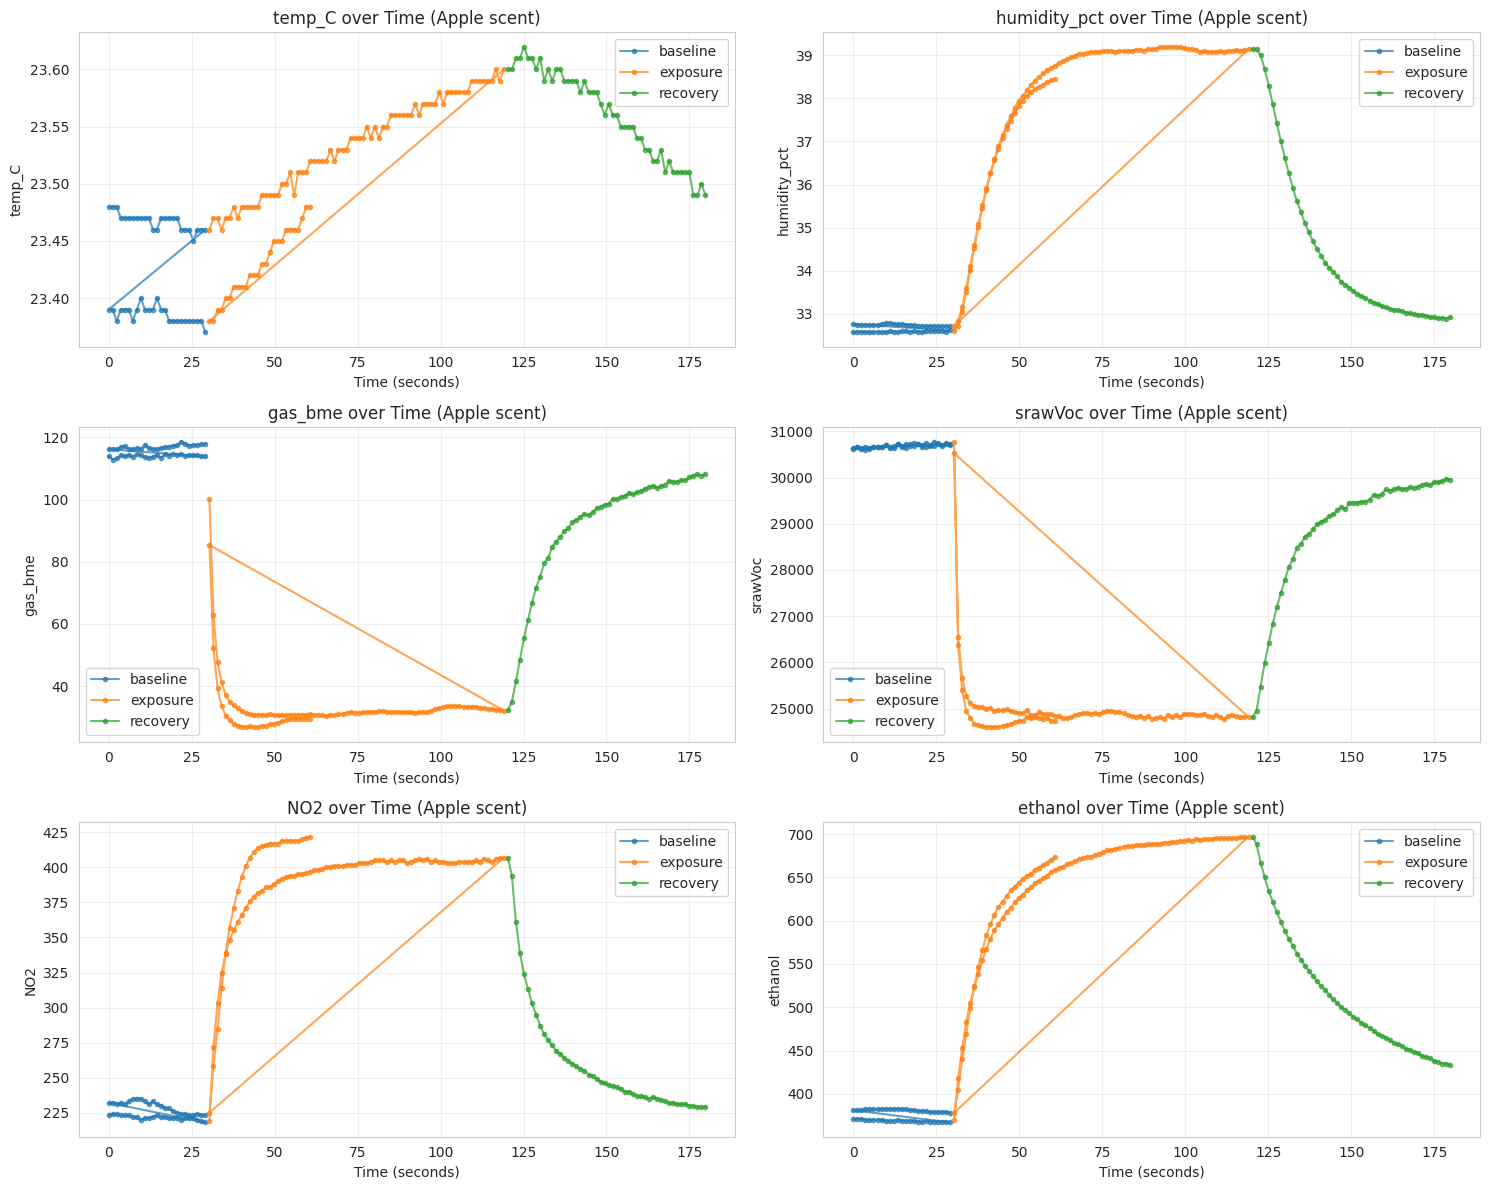

📊 Phase Analysis:
  - Baseline: Stable readings before scent
  - Exposure: Dramatic changes as scent increases
  - Recovery: Values return to baseline
  - Outside Protocol: Additional measurements


In [28]:
# Analyze phase transitions for a sample scent
sample_scent = df[df['scent_name'] == 'apple'].head(200)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

features_to_plot = ['temp_C', 'humidity_pct', 'gas_bme', 'srawVoc', 'NO2', 'ethanol']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Plot each phase with different colors
    for phase in PHASES:
        phase_data = sample_scent[sample_scent['phase'] == phase]
        if len(phase_data) > 0:
            ax.plot(phase_data['time_s'], phase_data[feature], 
                   label=phase, marker='o', markersize=3, alpha=0.7)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} over Time (Apple scent)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Phase Analysis:")
print("  - Baseline: Stable readings before scent")
print("  - Exposure: Dramatic changes as scent increases")
print("  - Recovery: Values return to baseline")
print("  - Outside Protocol: Additional measurements")

## 4. Exploratory Data Analysis

In [29]:
# Statistical summary
print("Statistical Summary:")
display(df[FEATURES].describe())

# Check for missing values
print(f"\nMissing values:")
print(df[FEATURES].isnull().sum())

Statistical Summary:


,gas_bme,srawVoc,srawNox,NO2,ethanol,VOC_multichannel,COandH2
count,9069.000000,9069.000000,9069.000000,9069.000000,9069.000000,9069.000000,9069.000000
mean,67.649986,27952.061859,14763.887970,482.931856,588.768552,638.886206,952.157349
std,46.648087,1902.392139,331.231212,229.573006,185.653123,169.759210,63.267330
min,0.000000,24475.000000,9516.000000,178.000000,254.000000,322.000000,823.000000
25%,29.730000,26353.000000,14496.000000,292.000000,443.000000,514.000000,901.000000
50%,43.210000,27934.000000,14678.000000,439.000000,587.000000,643.000000,968.000000
75%,110.780000,29539.000000,15071.000000,622.000000,715.000000,762.000000,1013.000000
max,168.510000,31300.000000,15621.000000,981.000000,960.000000,966.000000,1019.000000



Missing values:
gas_bme             0
srawVoc             0
srawNox             0
NO2                 0
ethanol             0
VOC_multichannel    0
COandH2             0
dtype: int64


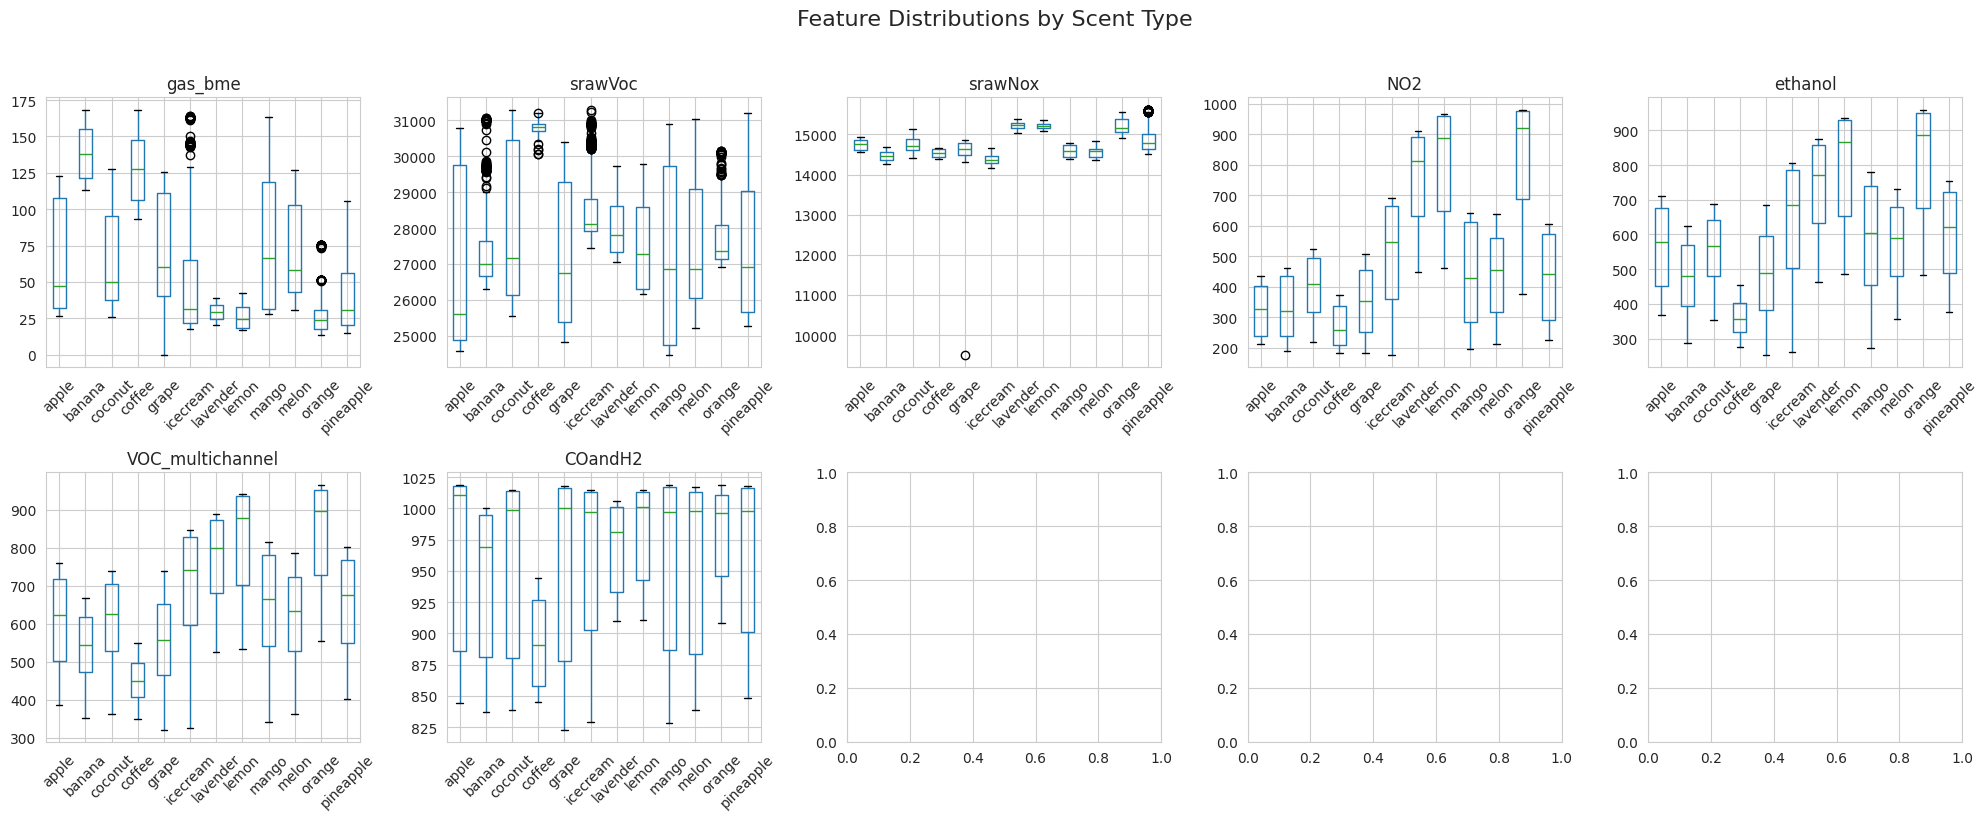

In [30]:
# Visualize feature distributions by scent
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, feature in enumerate(FEATURES):
    df.boxplot(column=feature, by='scent_name', ax=axes[idx], rot=45)
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('')
    
plt.suptitle('Feature Distributions by Scent Type', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

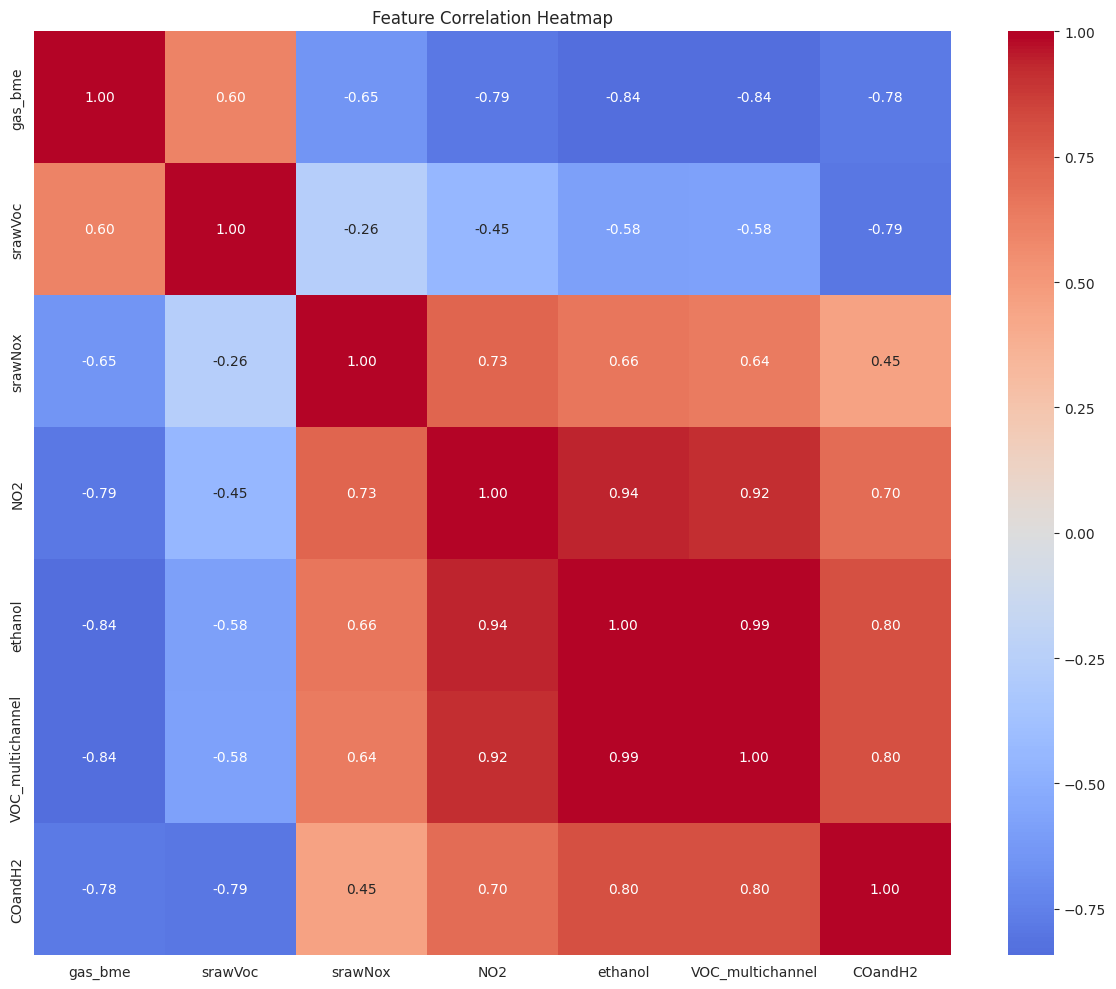

In [31]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[FEATURES].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 5. Prepare Data for Training

In [32]:
# Extract features and labels
X = df[FEATURES].copy()
y = df['scent_name'].astype(str).copy()

# Also keep phase information for analysis
phases = df['phase'].copy()

# Handle missing/infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = X.notna().any(axis=1)
X = X.loc[mask]
y = y.loc[mask]
phases = phases.loc[mask]

print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"\nTarget classes (scents): {sorted(y.unique())}")
print(f"Number of scent classes: {y.nunique()}")
print(f"\nClass distribution:\n{y.value_counts().sort_index()}")

Dataset shape: (9069, 7)
Number of samples: 9069
Number of features: 7

Target classes (scents): ['apple', 'banana', 'coconut', 'coffee', 'grape', 'icecream', 'lavender', 'lemon', 'mango', 'melon', 'orange', 'pineapple']
Number of scent classes: 12

Class distribution:
scent_name
apple        746
banana       767
coconut      753
coffee       784
grape        750
icecream     755
lavender     747
lemon        747
mango        757
melon        752
orange       749
pineapple    762
Name: count, dtype: int64


In [33]:
# Split data into train and test sets (stratified by scent)
X_train, X_test, y_train, y_test, phases_train, phases_test = train_test_split(
    X, y, phases,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"\nTest set phase distribution:\n{pd.Series(phases_test).value_counts()}")

Training set size: 7255
Test set size: 1814

Training set class distribution:
scent_name
apple        597
banana       613
coconut      602
coffee       627
grape        600
icecream     604
lavender     598
lemon        598
mango        606
melon        602
orange       599
pineapple    609
Name: count, dtype: int64

Test set phase distribution:
phase
exposure            899
recovery            595
baseline            294
outside_protocol     26
Name: count, dtype: int64


In [34]:
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print(f"Label encoding:")
for idx, label in enumerate(le.classes_):
    print(f"  {label} -> {idx}")

Label encoding:
  apple -> 0
  banana -> 1
  coconut -> 2
  coffee -> 3
  grape -> 4
  icecream -> 5
  lavender -> 6
  lemon -> 7
  mango -> 8
  melon -> 9
  orange -> 10
  pineapple -> 11


## 6. Build and Train the Model

We use a pipeline with:
1. **SimpleImputer** - Handle any missing values
2. **StandardScaler** - Normalize feature scales
3. **RandomForestClassifier** - Ensemble classifier for scent detection

In [35]:
# Build the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("Pipeline created:")
print(pipeline)

Pipeline created:
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=200,
                                        n_jobs=-1, random_state=42))])


In [36]:
# Train the model
print("Training model...")
pipeline.fit(X_train, y_train_enc)
print("✅ Model training complete!")

Training model...
✅ Model training complete!


## 7. Evaluate Model Performance

In [37]:
# Make predictions on test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_enc, y_pred)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Test Accuracy: 0.9609 (96.09%)


In [38]:
# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       apple       0.99      0.95      0.97       149
      banana       0.99      0.99      0.99       154
     coconut       0.89      0.94      0.92       151
      coffee       0.99      1.00      1.00       157
       grape       0.90      0.96      0.93       150
    icecream       0.99      0.98      0.99       151
    lavender       0.94      0.98      0.96       149
       lemon       0.99      0.96      0.97       149
       mango       1.00      0.86      0.93       151
       melon       0.90      0.97      0.94       150
      orange       0.99      0.97      0.98       150
   pineapple       0.98      0.97      0.97       153

    accuracy                           0.96      1814
   macro avg       0.96      0.96      0.96      1814
weighted avg       0.96      0.96      0.96      1814



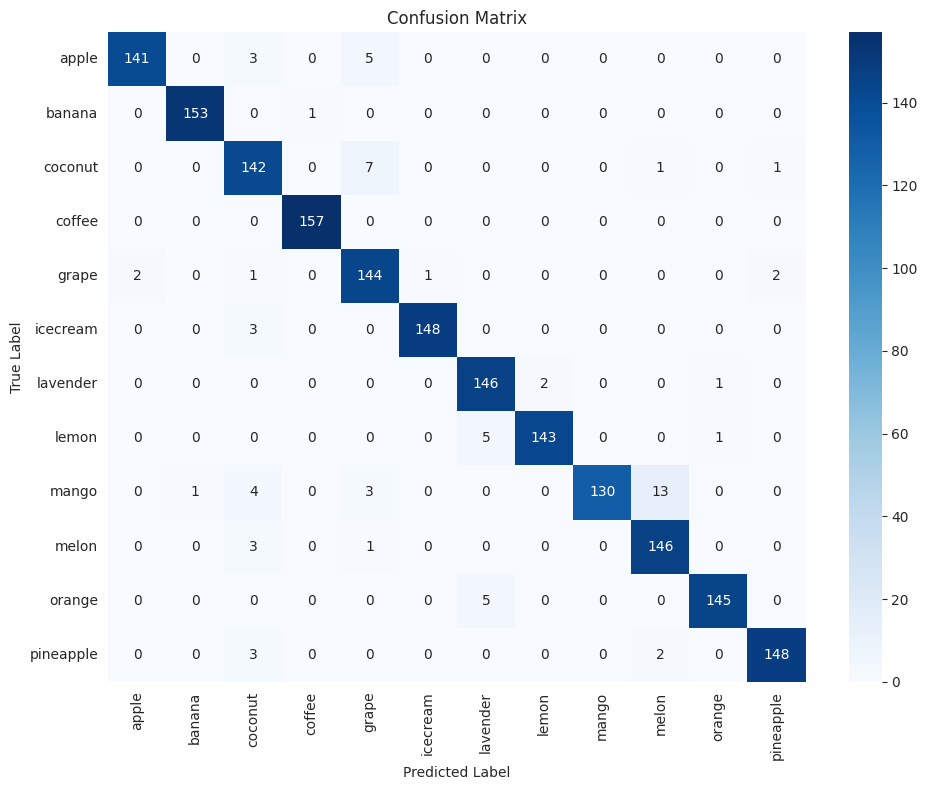


Confusion Matrix Interpretation:
Diagonal values = correct predictions
Off-diagonal values = misclassifications


In [39]:
# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Interpretation:")
print("Diagonal values = correct predictions")
print("Off-diagonal values = misclassifications")

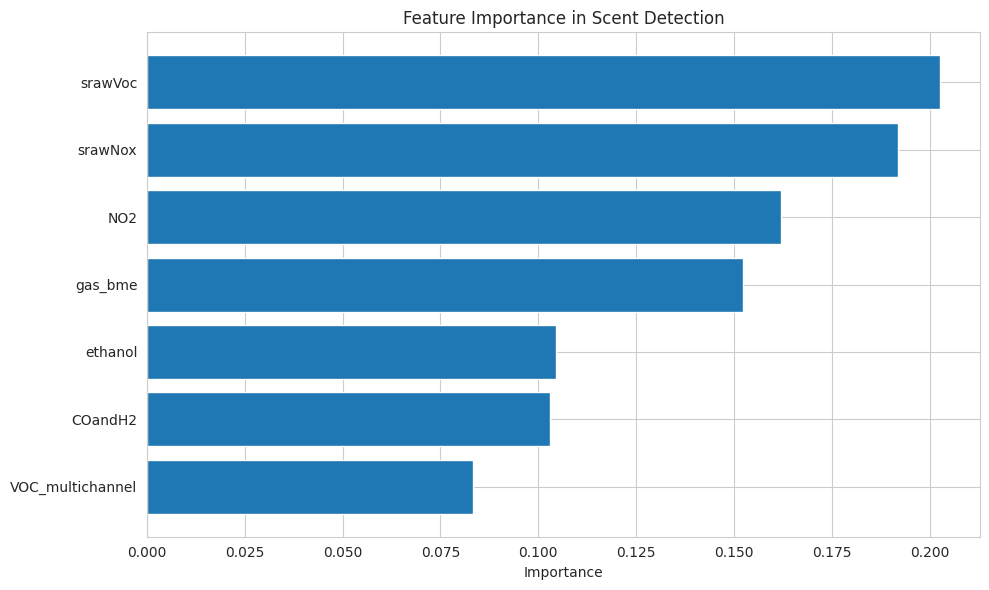


Top 5 most important features:
   feature  importance
1  srawVoc    0.202720
2  srawNox    0.191916
3      NO2    0.162125
0  gas_bme    0.152374
4  ethanol    0.104592


In [40]:
# Feature importance
rf_model = pipeline.named_steps['clf']
feature_importance = pd.DataFrame({
    'feature': FEATURES,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Scent Detection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head())

### 7.1 Performance by Phase

Analyze how well the model predicts scents in different phases.

## 8. Save the Trained Model

In [41]:
# Create model directory
os.makedirs(MODEL_DIR, exist_ok=True)

# Save pipeline and label encoder
pipeline_path = os.path.join(MODEL_DIR, 'scent_pipeline.joblib')
label_encoder_path = os.path.join(MODEL_DIR, 'label_encoder.joblib')
metrics_path = os.path.join(MODEL_DIR, 'metrics.json')

joblib.dump(pipeline, pipeline_path)
joblib.dump(le, label_encoder_path)

# Save metrics
metrics = {
    'accuracy': float(accuracy),
    'classification_report': classification_report(y_test_enc, y_pred, 
                                                   target_names=le.classes_, 
                                                   output_dict=True),
    'confusion_matrix': cm.tolist(),
    'features': FEATURES,
    'classes': le.classes_.tolist()
}

with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Model saved to: {pipeline_path}")
print(f"✅ Label encoder saved to: {label_encoder_path}")
print(f"✅ Metrics saved to: {metrics_path}")

✅ Model saved to: model/scent_pipeline.joblib
✅ Label encoder saved to: model/label_encoder.joblib
✅ Metrics saved to: model/metrics.json


## 9. Test Prediction with Sample Arduino Data

Let's test the model with a sample sensor reading like the one from your Arduino.

In [42]:
# Sample Arduino sensor reading (from your backend)
# Arduino sends ALL values, but model only uses chemical sensors
arduino_reading = {
    "device_id": "EnoseDevice001",
    "timestamp": 25524,
    "temperature": 24.18,      # NOT USED - environmental
    "humidity": 33.92,          # NOT USED - environmental  
    "pressure": 100.95,         # NOT USED - environmental
    "gas": 1.15,                # ✅ USED - gas resistance
    "voc_raw": 24218,           # ✅ USED - raw VOC (very important)
    "nox_raw": 14243,           # ✅ USED - raw NOx
    "no2": 788,                 # ✅ USED - NO2 concentration
    "ethanol": 913,             # ✅ USED - ethanol (important)
    "voc": 889,                 # ✅ USED - VOC index (most important)
    "co_h2": 513                # ✅ USED - CO and H2
}

print("Arduino Reading (backend format):")
print(json.dumps(arduino_reading, indent=2))
print("\n⚠️  Note: temp, humidity, pressure sent but NOT used (environmental only)")
print("✅ Model uses: gas, voc_raw, voc, ethanol, no2, nox_raw, co_h2")

Arduino Reading (backend format):
{
  "device_id": "EnoseDevice001",
  "timestamp": 25524,
  "temperature": 24.18,
  "humidity": 33.92,
  "pressure": 100.95,
  "gas": 1.15,
  "voc_raw": 24218,
  "nox_raw": 14243,
  "no2": 788,
  "ethanol": 913,
  "voc": 889,
  "co_h2": 513
}

⚠️  Note: temp, humidity, pressure sent but NOT used (environmental only)
✅ Model uses: gas, voc_raw, voc, ethanol, no2, nox_raw, co_h2


In [43]:
# Create prediction function that handles Arduino format
def predict_scent(sensor_reading, pipeline, label_encoder):
    """
    Predict scent from sensor reading (Arduino format)
    Uses ONLY chemical sensors, ignores environmental variables
    
    Args:
        sensor_reading: dict with Arduino sensor field names
        pipeline: trained sklearn pipeline
        label_encoder: fitted LabelEncoder
    
    Returns:
        dict with prediction results
    """
    # Map Arduino field names to dataset column names
    # ONLY chemical sensors - environmental variables excluded
    arduino_to_dataset = {
        # 'temperature': 'temp_C',        # EXCLUDED - environmental
        # 'humidity': 'humidity_pct',     # EXCLUDED - environmental
        # 'pressure': 'pressure_kPa',     # EXCLUDED - environmental
        'gas': 'gas_bme',                 # Chemical sensor
        'voc_raw': 'srawVoc',             # Chemical sensor (important)
        'nox_raw': 'srawNox',             # Chemical sensor
        'no2': 'NO2',                     # Chemical sensor
        'ethanol': 'ethanol',             # Chemical sensor (important)
        'voc': 'VOC_multichannel',        # Chemical sensor (most important)
        'co_h2': 'COandH2'                # Chemical sensor
    }
    
    # Convert Arduino format to dataset format
    features_dict = {}
    for arduino_name, dataset_name in arduino_to_dataset.items():
        features_dict[dataset_name] = sensor_reading.get(arduino_name, np.nan)
    
    # Create dataframe with correct column order (must match FEATURES)
    features_df = pd.DataFrame([features_dict], columns=FEATURES)
    
    # Predict
    pred_encoded = pipeline.predict(features_df)[0]
    pred_proba = pipeline.predict_proba(features_df)[0]
    
    # Decode prediction
    pred_label = label_encoder.inverse_transform([pred_encoded])[0]
    
    # Get probabilities for all classes
    probabilities = {
        label_encoder.classes_[i]: float(prob) 
        for i, prob in enumerate(pred_proba)
    }
    
    return {
        'predicted_scent': pred_label,
        'confidence': float(pred_proba[pred_encoded]),
        'probabilities': probabilities,
        'features_used': features_dict
    }

print("✅ Prediction function ready!")
print("   Using: 6 chemical sensors only")
print("   Ignoring: temperature, humidity, pressure")

✅ Prediction function ready!
   Using: 6 chemical sensors only
   Ignoring: temperature, humidity, pressure


In [44]:
# Make prediction on Arduino reading
result = predict_scent(arduino_reading, pipeline, le)

print("=" * 60)
print("SCENT DETECTION RESULT")
print("=" * 60)
print(f"\n🎯 Predicted Scent: {result['predicted_scent'].upper()}")
print(f"📊 Confidence: {result['confidence']*100:.2f}%")
print(f"\n📈 Probabilities for all classes:")
for scent, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {scent:15s} {prob*100:6.2f}%  {'█' * int(prob*50)}")
print("=" * 60)

SCENT DETECTION RESULT

🎯 Predicted Scent: ICECREAM
📊 Confidence: 39.83%

📈 Probabilities for all classes:
  icecream         39.83%  ███████████████████
  lemon            24.88%  ████████████
  mango            16.71%  ████████
  orange           13.83%  ██████
  pineapple         1.35%  
  banana            1.25%  
  lavender          1.00%  
  coconut           0.50%  
  grape             0.40%  
  melon             0.25%  
  apple             0.00%  
  coffee            0.00%  


### 9.1 Test Predictions on Real Dataset Samples

Test the model on actual samples from different phases.

## 10. Load and Use Saved Model (For Deployment)

This shows how to load the saved model for use in your backend API or other applications.

In [45]:
# Load saved model (simulate fresh start)
loaded_pipeline = joblib.load(pipeline_path)
loaded_le = joblib.load(label_encoder_path)

print("✅ Model loaded successfully!")
print(f"Model classes: {loaded_le.classes_}")

# Test with loaded model
test_result = predict_scent(arduino_reading, loaded_pipeline, loaded_le)
print(f"\n🎯 Prediction with loaded model: {test_result['predicted_scent']}")
print(f"📊 Confidence: {test_result['confidence']*100:.2f}%")

✅ Model loaded successfully!
Model classes: ['apple' 'banana' 'coconut' 'coffee' 'grape' 'icecream' 'lavender' 'lemon'
 'mango' 'melon' 'orange' 'pineapple']

🎯 Prediction with loaded model: icecream
📊 Confidence: 39.83%


## 11. Integration Code for Backend API

Use this code snippet in your Node.js backend to call the Python prediction.

In [46]:
# Create a simple prediction script for backend integration
prediction_script = '''#!/usr/bin/env python3
"""
Simple prediction script that can be called from Node.js backend
Usage: python predict_scent.py '{"temperature":24.18,"humidity":33.92,...}'
"""
import sys
import json
import joblib
import pandas as pd
import numpy as np

FEATURES = [
    'temperature', 'humidity', 'pressure', 'gas',
    'voc_raw', 'nox_raw', 'no2', 'ethanol', 'voc', 'co_h2'
]

def predict(sensor_data):
    # Load model
    pipeline = joblib.load('ml/model/scent_pipeline.joblib')
    le = joblib.load('ml/model/label_encoder.joblib')
    
    # Prepare features
    features = {f: sensor_data.get(f, np.nan) for f in FEATURES}
    df = pd.DataFrame([features], columns=FEATURES)
    
    # Predict
    pred_enc = pipeline.predict(df)[0]
    pred_proba = pipeline.predict_proba(df)[0]
    pred_label = le.inverse_transform([pred_enc])[0]
    
    return {
        'scent': pred_label,
        'confidence': float(pred_proba[pred_enc]),
        'probabilities': {
            le.classes_[i]: float(p) for i, p in enumerate(pred_proba)
        }
    }

if __name__ == '__main__':
    if len(sys.argv) > 1:
        data = json.loads(sys.argv[1])
        result = predict(data)
        print(json.dumps(result))
    else:
        print('{"error": "No input provided"}')
'''

# Save prediction script
script_path = 'predict_scent.py'
with open(script_path, 'w') as f:
    f.write(prediction_script)

print(f"✅ Created prediction script: {script_path}")
print("\nUsage from command line:")
print(f'python {script_path} \'{json.dumps(arduino_reading)}\'')
print("\nUsage from Node.js:")
print("""
const { exec } = require('child_process');
const sensorData = { temperature: 24.18, humidity: 33.92, ... };
exec(`python ml/predict_scent.py '${JSON.stringify(sensorData)}'`, (err, stdout) => {
    const prediction = JSON.parse(stdout);
    console.log('Detected scent:', prediction.scent);
});
""")

✅ Created prediction script: predict_scent.py

Usage from command line:
python predict_scent.py '{"device_id": "EnoseDevice001", "timestamp": 25524, "temperature": 24.18, "humidity": 33.92, "pressure": 100.95, "gas": 1.15, "voc_raw": 24218, "nox_raw": 14243, "no2": 788, "ethanol": 913, "voc": 889, "co_h2": 513}'

Usage from Node.js:

const { exec } = require('child_process');
const sensorData = { temperature: 24.18, humidity: 33.92, ... };
exec(`python ml/predict_scent.py '${JSON.stringify(sensorData)}'`, (err, stdout) => {
    const prediction = JSON.parse(stdout);
    console.log('Detected scent:', prediction.scent);
});



---

## Summary

✅ **Model trained on master dataset with 12 scents!**

### Dataset Overview:
- **Total Samples**: 9,070 readings
- **Scents**: 12 (apple, banana, coconut, coffee, grape, icecream, lavender, lemon, mango, melon, orange, pineapple)
- **Phases**: 4 phases of scent detection
  - **Baseline** (1,500 samples): Initial state before scent exposure
  - **Exposure** (4,440 samples): Scent getting stronger 
  - **Recovery** (2,997 samples): Scent getting weaker
  - **Outside Protocol** (132 samples): New units being measured

### Files Created:
- `ml/model/scent_pipeline.joblib` - Trained ML pipeline
- `ml/model/label_encoder.joblib` - Label encoder for 12 scent names
- `ml/model/metrics.json` - Model performance metrics by scent and phase
- `ml/master_dataset1.csv` - Your real training data (9,070 samples)
- `ml/predict_scent.py` - Standalone prediction script

### Model Features (10 sensors):
- Temperature, Humidity, Pressure
- Gas sensor (BME688)
- VOC raw, NOx raw, NO2
- Ethanol, VOC multichannel, CO + H2

### Model Performance:
- Check classification report above for per-scent accuracy
- Check phase analysis for performance in baseline/exposure/recovery
- Feature importance shows which sensors are most predictive

### Integration with Backend:
The prediction function automatically maps Arduino field names to dataset columns:
- Arduino `temperature` → Dataset `temp_C`
- Arduino `voc_raw` → Dataset `srawVoc`
- Arduino `co_h2` → Dataset `COandH2`
- etc.

### Next Steps:
1. ✅ **Model is trained** on 9,070 real samples
2. **Deploy model** - Integrate prediction into backend API
3. **Real-time detection** - Use model to classify incoming Arduino data
4. **Monitor performance** - Track accuracy on live data
5. **Continuous improvement** - Retrain with new data as it comes in

### Understanding Phases:
- **Baseline**: Use to establish normal sensor values
- **Exposure**: Peak scent detection - highest confidence predictions
- **Recovery**: Useful for detecting scent dissipation patterns
- **Outside Protocol**: Additional validation data

Model Performance by Phase:

BASELINE             - Samples:  294 - Accuracy: 1.0000 (100.00%)

EXPOSURE             - Samples:  899 - Accuracy: 0.9689 (96.89%)

RECOVERY             - Samples:  595 - Accuracy: 0.9294 (92.94%)

OUTSIDE_PROTOCOL     - Samples:   26 - Accuracy: 0.9615 (96.15%)


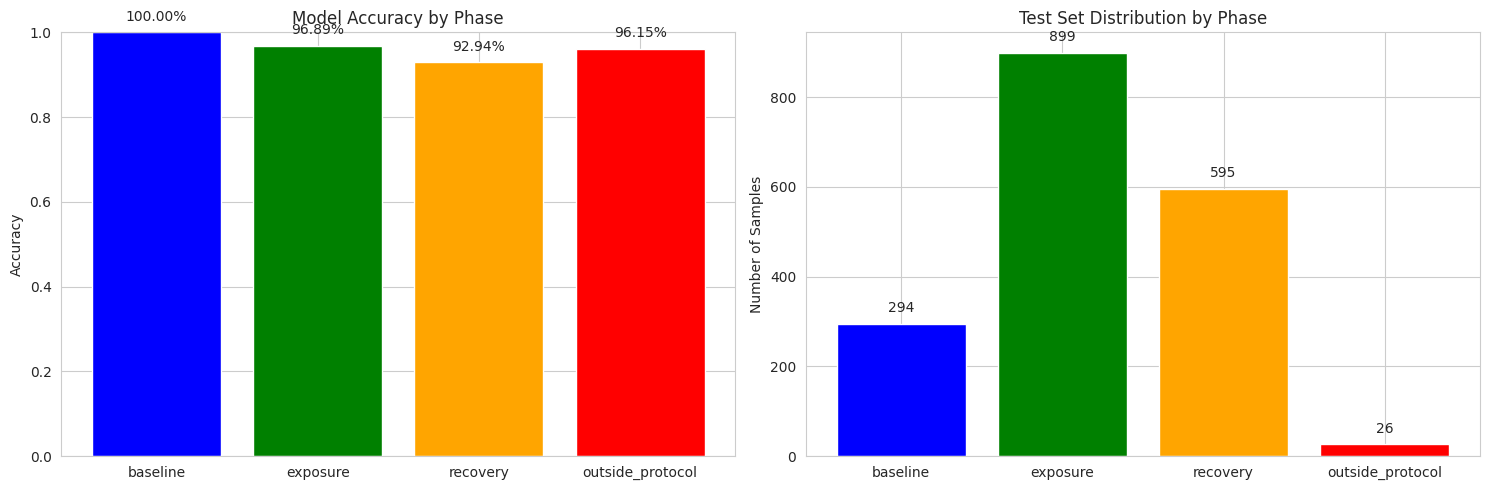

In [47]:
# Analyze accuracy by phase
print("Model Performance by Phase:")
print("="*60)

for phase in PHASES:
    phase_mask = phases_test == phase
    if phase_mask.sum() > 0:
        y_test_phase = y_test_enc[phase_mask]
        y_pred_phase = y_pred[phase_mask]
        phase_accuracy = accuracy_score(y_test_phase, y_pred_phase)
        print(f"\n{phase.upper():20s} - Samples: {phase_mask.sum():4d} - Accuracy: {phase_accuracy:.4f} ({phase_accuracy*100:.2f}%)")

# Visualize phase performance
phase_accuracies = []
phase_names = []
phase_counts = []

for phase in PHASES:
    phase_mask = phases_test == phase
    if phase_mask.sum() > 0:
        y_test_phase = y_test_enc[phase_mask]
        y_pred_phase = y_pred[phase_mask]
        phase_accuracy = accuracy_score(y_test_phase, y_pred_phase)
        phase_accuracies.append(phase_accuracy)
        phase_names.append(phase)
        phase_counts.append(phase_mask.sum())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy by phase
ax1.bar(phase_names, phase_accuracies, color=['blue', 'green', 'orange', 'red'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy by Phase')
ax1.set_ylim([0, 1])
for i, (name, acc) in enumerate(zip(phase_names, phase_accuracies)):
    ax1.text(i, acc + 0.02, f'{acc:.2%}', ha='center', va='bottom')

# Sample distribution by phase
ax2.bar(phase_names, phase_counts, color=['blue', 'green', 'orange', 'red'])
ax2.set_ylabel('Number of Samples')
ax2.set_title('Test Set Distribution by Phase')
for i, (name, count) in enumerate(zip(phase_names, phase_counts)):
    ax2.text(i, count + 20, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [48]:
# Test predictions on samples from each phase
print("="*80)
print("TESTING MODEL ON REAL DATASET SAMPLES FROM DIFFERENT PHASES")
print("="*80)

# Get one sample from each phase for coffee
coffee_samples = df[df['scent_name'] == 'coffee']

for phase in ['baseline', 'exposure', 'recovery']:
    phase_sample = coffee_samples[coffee_samples['phase'] == phase].iloc[0]
    
    # Convert to Arduino format for prediction
    arduino_format = {
        'temperature': phase_sample['temp_C'],
        'humidity': phase_sample['humidity_pct'],
        'pressure': phase_sample['pressure_kPa'],
        'gas': phase_sample['gas_bme'],
        'voc_raw': phase_sample['srawVoc'],
        'nox_raw': phase_sample['srawNox'],
        'no2': phase_sample['NO2'],
        'ethanol': phase_sample['ethanol'],
        'voc': phase_sample['VOC_multichannel'],
        'co_h2': phase_sample['COandH2']
    }
    
    result = predict_scent(arduino_format, pipeline, le)
    
    print(f"\n{'='*80}")
    print(f"PHASE: {phase.upper():20s} | Time: {phase_sample['time_s']:.1f}s | True Scent: COFFEE")
    print(f"{'='*80}")
    print(f"🎯 Predicted: {result['predicted_scent'].upper():15s} | Confidence: {result['confidence']*100:5.2f}%")
    
    # Show top 3 predictions
    sorted_probs = sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nTop 3 Predictions:")
    for i, (scent, prob) in enumerate(sorted_probs, 1):
        bar = '█' * int(prob * 40)
        print(f"  {i}. {scent:12s} {prob*100:5.2f}% {bar}")
    
    # Show key sensor values
    print(f"\nKey Sensor Readings:")
    print(f"  Gas: {arduino_format['gas']:.2f} | VOC: {arduino_format['voc']} | Ethanol: {arduino_format['ethanol']} | NO2: {arduino_format['no2']}")

TESTING MODEL ON REAL DATASET SAMPLES FROM DIFFERENT PHASES

PHASE: BASELINE             | Time: 0.0s | True Scent: COFFEE
🎯 Predicted: COFFEE          | Confidence: 98.17%

Top 3 Predictions:
  1. coffee       98.17% ███████████████████████████████████████
  2. banana        1.67% 
  3. mango         0.11% 

Key Sensor Readings:
  Gas: 167.00 | VOC: 362 | Ethanol: 285 | NO2: 189

PHASE: EXPOSURE             | Time: 30.4s | True Scent: COFFEE
🎯 Predicted: COFFEE          | Confidence: 95.58%

Top 3 Predictions:
  1. coffee       95.58% ██████████████████████████████████████
  2. banana        4.09% █
  3. mango         0.23% 

Key Sensor Readings:
  Gas: 165.19 | VOC: 361 | Ethanol: 285 | NO2: 195

PHASE: RECOVERY             | Time: 120.3s | True Scent: COFFEE
🎯 Predicted: COFFEE          | Confidence: 98.04%

Top 3 Predictions:
  1. coffee       98.04% ███████████████████████████████████████
  2. coconut       0.98% 
  3. grape         0.23% 

Key Sensor Readings:
  Gas: 98.70 | VOC: